## Train the model with small train set
All functions, like **get_bow_representation()** and **get_vocabulary()**, offer the possibility to store the result into a file by passing the parameter **'save=True'**

In [ ]:
import build_vocabulary as bv
import features_extraction as fe
import train_classifier as tc

iterations = []
types = []
test_accuracy = []
train_accuracy = []


for iter in range(250, 5000, 250):
    voc = bv.get_vocabulary(path='../data/train/', numWords=iter)
    train_data = fe.get_bow_representation(voc, path='../data/train')
    w, b = tc.train_classifier(train_data)

    logits, predictions, accuracy_train = tc.inference_classifier(
        train_data, w, b)

    iterations.append(iter)
    types.append('classic model')
    train_accuracy.append(accuracy_train)

    test_data = fe.get_bow_representation(voc, path='../data/test')
    logits, predictions, accuracy_test = tc.inference_classifier(
        test_data, w, b)
    test_accuracy.append(accuracy_test)

## The model ignores very common words

In [ ]:
words_to_ignore = []
f = open('../data/stopwords.txt', 'r')
n = 0
for w in f.read().split():
    words_to_ignore.append(w)
    n += 1
f.close()
for iter in range(250, 5000, 250):
    voc = bv.get_vocabulary(path='../data/train/', numWords=iter)
    voc_no_common_words = [word for word in voc if word not in words_to_ignore]

    train_data = fe.get_bow_representation(voc_no_common_words)
    w, b = tc.train_classifier(train_data)

    logits, predictions, accuracy_train = tc.inference_classifier(
        train_data, w, b)

    iterations.append(iter)
    types.append('Model without common words')
    train_accuracy.append(accuracy_train)

    test_data = fe.get_bow_representation(
        voc_no_common_words, path='../data/test')
    logits, predictions, accuracy_test = tc.inference_classifier(
        test_data, w, b)
    test_accuracy.append(accuracy_test)

## Model with stemming

In [ ]:
for iter in range(250, 5000, 250):
    voc = bv.get_vocabulary(path='../data/train/', numWords=iter)

    voc_stem = fe.stem_words(voc)
    train_data = fe.get_bow_representation(voc_stem, stemming=True)
    w, b = tc.train_classifier(train_data)

    logits, predictions, accuracy_train = tc.inference_classifier(
        train_data, w, b)

    iterations.append(iter)
    types.append('Model with stemming')
    train_accuracy.append(accuracy_train)

    test_data = fe.get_bow_representation(
        voc_stem, path='../data/test', stemming=True)
    logits, predictions, accuracy_test = tc.inference_classifier(
        test_data, w, b)
    test_accuracy.append(accuracy_test)

## Model with stemming and ignore common words

In [ ]:
for iter in range(250, 5000, 250):
    voc = bv.get_vocabulary(path='../data/train/', numWords=iter)
    voc_no_common_words = [word for word in voc if word not in words_to_ignore]

    voc_stem_no_cwords = fe.stem_words(voc_no_common_words)

    train_data = fe.get_bow_representation(voc_stem_no_cwords, stemming=True)
    w, b = tc.train_classifier(train_data)

    logits, predictions, accuracy_train = tc.inference_classifier(
        train_data, w, b)

    iterations.append(iter)
    types.append('Model with stemming and without common words')
    train_accuracy.append(accuracy_train)

    test_data = fe.get_bow_representation(
        voc_stem_no_cwords, path='../data/test', stemming=True)
    logits, predictions, accuracy_test = tc.inference_classifier(
        test_data, w, b)
    test_accuracy.append(accuracy_test)

## 1.4 Compare different models

<Axes: title={'center': 'Test accuracy for different models'}, xlabel='Vocabulary size', ylabel='Accuracy (%)'>

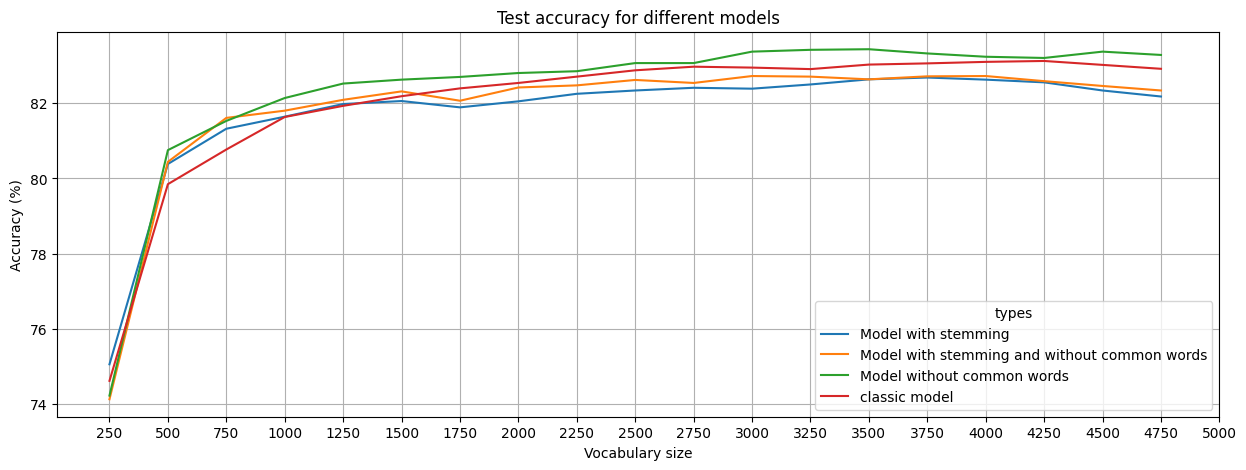

In [2]:
import pandas as pd

# results = pd.DataFrame({'Vocabulary size': iterations, 'types': types,
#                        'test_accuracy': test_accuracy, 'train_accuracy': train_accuracy})
# results.to_csv('results.csv', index=True)

results=pd.read_csv('results.csv')
results1 = results.pivot(
    index='Vocabulary size', columns='types', values='test_accuracy')


results1.plot(kind='line', title='Test accuracy for different models',
              legend=True, grid=True, figsize=(15, 5), xticks=range(250, 5250, 250), ylabel='Accuracy (%)')

## 1.5 Analysis
Identify the set of most impactful words on the predictions made by the model.  
Also identify the worst errors on the test set, that is, those that the model classifies
with the highest confidence.  
The analysis are made using the model without common words, because it has the highest accuracy

In [13]:
import build_vocabulary as bv
import features_extraction as fe
import train_classifier as tc

import pandas as pd
words_to_ignore = []
f = open('../data/stopwords.txt', 'r')
n = 0
for w in f.read().split():
    words_to_ignore.append(w)
    n += 1
f.close()

voc = bv.get_vocabulary(path='../data/train/', numWords=5000)
voc_no_common_words = [word for word in voc if word not in words_to_ignore]

train_data = fe.get_bow_representation(voc_no_common_words)
w, b = tc.train_classifier(train_data)

test_data,file_names = fe.get_bow_representation(
    voc_no_common_words, path='../data/test',get_file_names=True)
logits, predictions, accuracy_test = tc.inference_classifier(
    test_data, w, b)

Y = test_data[:, -1]



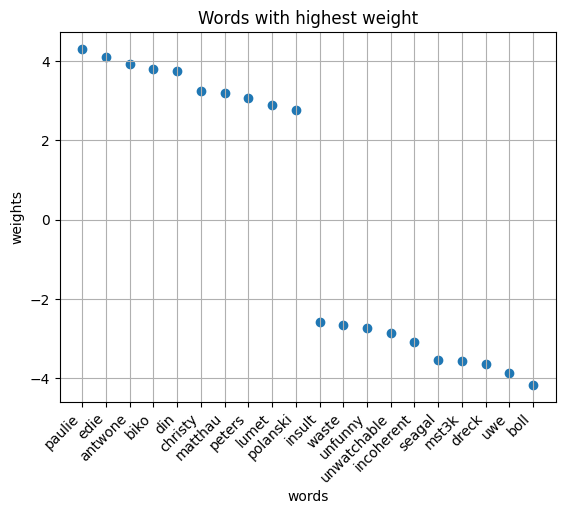

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
words_weights=pd.DataFrame({'words':voc_no_common_words,'weights':w})
words_weights.sort_values(by='weights',ascending=False,inplace=True)
words=pd.concat([words_weights.head(10),words_weights.tail(10)])
plt.scatter(x=words['words'],y=words['weights'])
plt.grid()
plt.xticks(rotation=45, ha='right')
plt.title('Words with highest weight')
plt.xlabel('words')
plt.ylabel('weights')
plt.show()

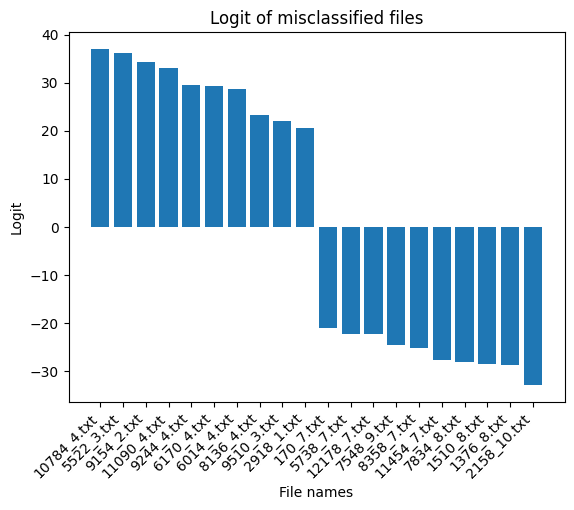

In [11]:
import matplotlib.pyplot as plt
logits_misclassified = logits[predictions != Y]

misclassified = pd.DataFrame(
    {'logits': logits_misclassified, 'file_names': file_names[predictions != Y]})
misclassified.sort_values(by='logits', ascending=False, inplace=True)

false_positive = misclassified.head(10)
false_negative = misclassified.tail(10)
false= pd.concat([false_positive,false_negative])
plt.bar(height=false['logits'], x=false['file_names'])
plt.xticks(rotation=45, ha='right')
plt.title('Logit of misclassified files')
plt.xlabel('File names')
plt.ylabel('Logit')
plt.show()

## Use logistic regression instead of naive baesian classifier

In [1]:
import build_vocabulary as bv
import features_extraction as fe
import logistic_regression as lr
words_to_ignore = []
f = open('../data/stopwords.txt', 'r')
n = 0
for w in f.read().split():
    words_to_ignore.append(w)
    n += 1
f.close()

voc = bv.get_vocabulary(path='../data/smalltrain/', numWords=1000)
voc_no_common_words = [word for word in voc if word not in words_to_ignore]

train_data = fe.get_bow_representation(voc_no_common_words)
w, b,accs,loss = lr.logreg_train(train_data,lr=0.005,steps=700000,batch_size=500)

test_data,file_names = fe.get_bow_representation(
    voc_no_common_words, path='../data/test',get_file_names=True)
probability = lr.logreg_inference(test_data[:,:-1],w,b)

Y = test_data[:, -1]
predictions = (probability > 0).astype(int)
accuracy = (predictions == Y).mean()*100
print(accuracy)

0
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000
200000
210000
220000
230000
240000
250000
260000
270000
280000
290000
300000
310000
320000
330000
340000
350000
360000
370000
380000
390000
400000
410000
420000
430000
440000
450000
460000
470000
480000
490000
500000
510000
520000
530000
540000
550000
560000
570000
580000
590000
600000
610000
620000
630000
640000
650000
660000
670000
680000
690000
50.0


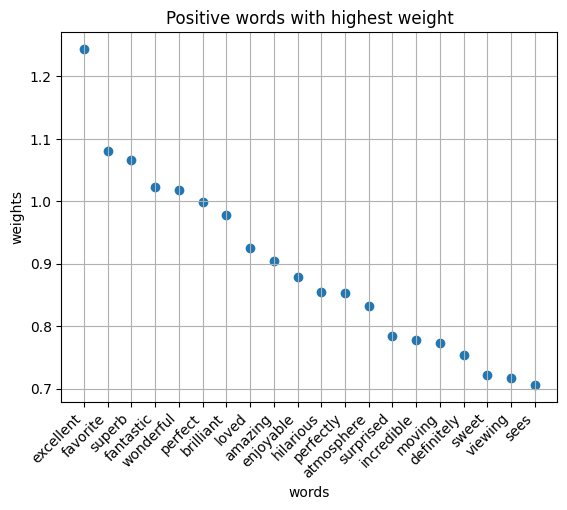

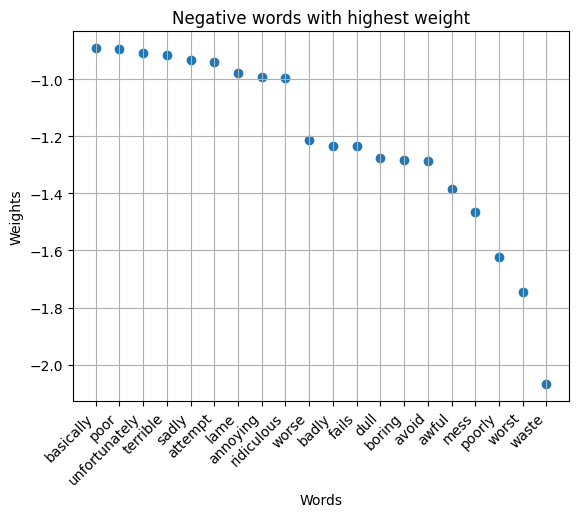

50.0


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
words_weights=pd.DataFrame({'words':voc_no_common_words,'weights':w})
words_weights.sort_values(by='weights',ascending=False,inplace=True)
positive_words=words_weights.head(20)
negative_words=words_weights.tail(20)
plt.scatter(x=positive_words['words'],y=positive_words['weights'])
plt.grid()
plt.xticks(rotation=45, ha='right')
plt.title('Positive words with highest weight')
plt.xlabel('words')
plt.ylabel('weights')
plt.show()

plt.scatter(x=negative_words['words'],y=negative_words['weights'])
plt.grid()
plt.xticks(rotation=45, ha='right')
plt.title('Negative words with highest weight')
plt.xlabel('Words')
plt.ylabel('Weights')
plt.show()
print(accuracy)